# SanityCheck

It is often necessary to perform a quick sanity check on some of the data you are working with. For example, you may be running a long term simulation and want some automated plots to give you a quick insight into whether the simulation is stable and producing plausible results. Or you want to get an overview of a data set you are going to analyse, but you do not yet have a feel for the data ranges.  

Command line tools such as `ncview` and `ncdump` give a good first look, but lack of some statistics, individual behaviour, and automation.   

The SanityCheck.py provided with `SLOTH` provides a tool for this purpose, both as a standalone command line tool and as a Python library suitable for inclusion in any Python workflow.

Folowing an example of how to use SanityCheck.py and what the results does look like.

## Preparation

First, we have to make `SLOTH` available to import by Python. If you already have added `SLOTH` to your `PYHTONPATH`, below step is not needed.

In [1]:
import os
import sys

cwd = os.getcwd()
sloth_path = f"{cwd}/../"
sys.path.append(sloth_path)

Second, we need to import all libraries needed in the following example.

In [2]:
%matplotlib inline
import matplotlib as mpl
import numpy as np
import netCDF4 as nc
import os

import sloth.SanityCheck
cwd = os.getcwd()

## Example

First we have to read in some data we can apply the SanityCheck. For this example we take some of the `SLOTH` example data provided under the `data/` directory. In particular we rad in the `T_2M` variable stored in `T_2M_COSMO.nc` 

In [10]:
FileName = f'{cwd}/../data/T_2M_COSMO.nc'

with nc.Dataset(FileName, 'r') as nc_file:
    # print some information about the variable we are going to read in
    print(f'nc_file.variables["T_2M"]: \n{nc_file.variables["T_2M"]}')
    T_2M = nc_file.variables['T_2M'][...]
    T_2M_long_name = nc_file.variables['T_2M'].long_name
    T_2M_units     = nc_file.variables['T_2M'].units
    

nc_file.variables["T_2M"]: 
<class 'netCDF4._netCDF4.Variable'>
float32 T_2M(time, rlat, rlon)
    standard_name: air_temperature
    long_name: 2m temperature
    units: K
    grid_mapping: rotated_pole
    coordinates: height_2m lat lon
unlimited dimensions: time
current shape = (8, 438, 450)
filling off


To run the sanity check, we simply have to pass `T_2M` to the `plot_SanityCheck()` function.

/p/software/jurecadc/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


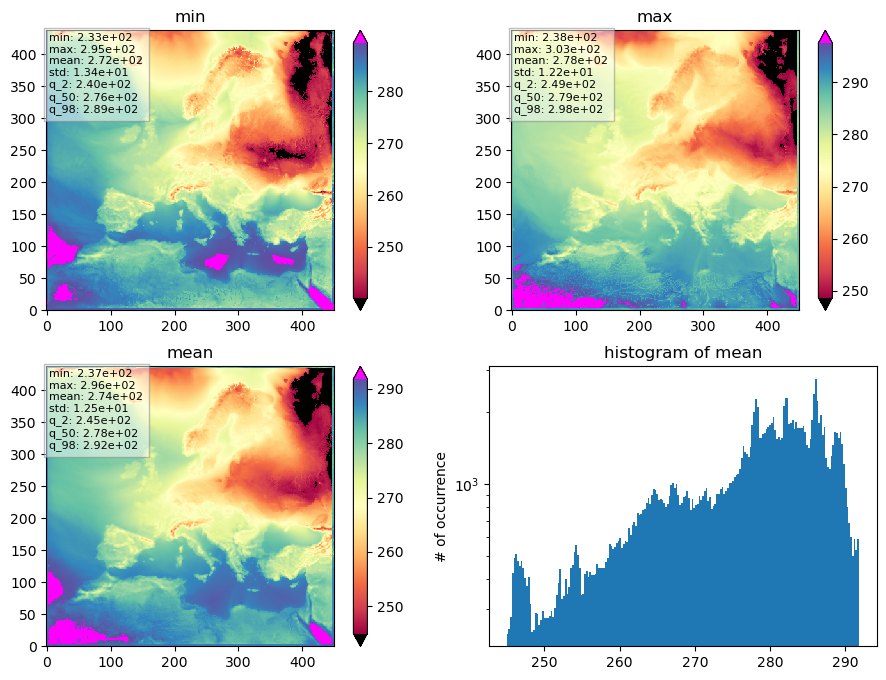

In [4]:
sloth.SanityCheck.plot_SanityCheck(data=T_2M, interactive=True)

What we get is a quiet simple plot consisting of 4 subplots, labeled as 'min', 'max', 'mean', and 'histogram of mean'. We do not see any further explanation, units, or geographical coordinates, but if we know what we put in, we already have a rough idea of what is plotted there. And this is what `plot_SanityCheck()` was written for, to be robust and to plot whatever data is passed.

However, we can  get some more information if we take a look at the internal documentation of `plot_SanityCheck()`.

In [5]:
print(sloth.SanityCheck.plot_SanityCheck.__doc__)


    Plot a sanity check for given data.
    
    The Sanity Plot is a plot consisting of 4 sub-plots, trying to visualise 
    some important statistics in a compact way, aimed to determine if the data 
    set inspected is plausible or not (sanity).

    Parameters
    ----------
    data : numpy.ma.MaskedArray
        3D array of data.
    kind : {'sum', 'mean'}, optional
        Calculation type for the data statistics. Default is 'sum'.
    figname : str, optional
        File name to save the plot. Default is './SanityCheck_3D.pdf'.
    fig_title : str, optional
        Title of the plot.
    lowerP : int, optional
        Lower percentile value for plot limits. Default is 2.
    upperP : int, optional
        Upper percentile value for plot limits. Default is 98.
    interactive : bool, optional
        If True, display the plot interactively. If False, save the plot to 
        'figname'. Default is False.
    cmapName : str, optional
        Name of the colormap. Default is 'S

We see that we can pass a title (`fig_title`), but no other descriptive arguments. So lets take the information from the netCDF attributes, and plot to the title.     
Further we can pass a colormap (`cmapName`), so lets use a colormap where hot temperature are plotted reddish and cool temperature are plotted bluish. 

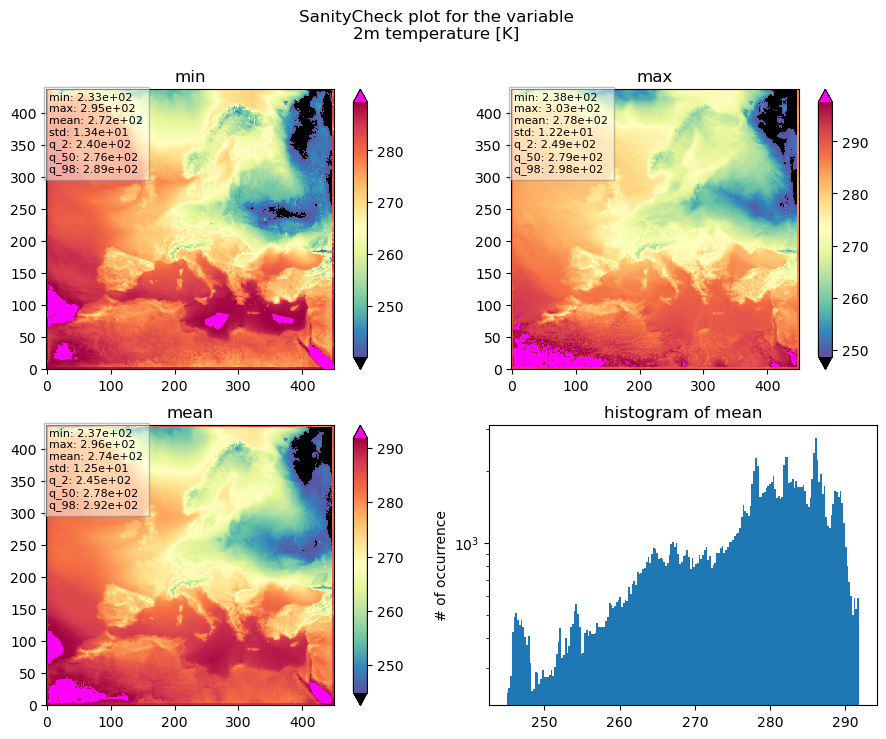

In [13]:
fig_title_list = [
    f'SanityCheck plot for the variable',
    f'{T_2M_long_name} [{T_2M_units}]',
]
fig_title = '\n'.join(fig_title_list)

sloth.SanityCheck.plot_SanityCheck(data=T_2M, interactive=True,
                fig_title=fig_title, cmapName='Spectral_r')

Now we know that we are looking at a SanityCheck plot for the `2m temperature`, which is given in `[K]`.   
The top left plot shows the minimum temperature for each pixel for the entire time period passed.    
The top right plot shows the maximum temperature for each pixel for the entire time period passed.   
The bottom left plot shows the average temperature for each pixel for the entire time period passed.  
And the lower right plot shows the histogram of the mean temperature.   

This gives us some information to help us decide whether or not the results are reasonable.    
Does the value range fit our expectations? Are we seeing warm temperatures in the south and cold temperatures in the north? Is the temperature distribution of temperatures between land and sea reasonable? Are the extremes within a valid range or or is the temperature dropping too much at night, for example?

The colorbar range is controlled by an upper and an lower percentile (in plot above the 2% and 98% percentiles) of the data values within each subplot. So the lower percentile defines the minimum value of the colorbar and the upper percentile defines the maximum value of the colorbar. Values outside the colorbar range are plotted with an extra colour that is well distinguished from the main colorbar. This behaviour is chosen, to make the colorbar robust against outliers.  

In order to capture values outside this truncated data range, there is a small box in the upper left corner of each subplot that displays some additional numbers, calculated based on the data values plotted within the subplot. These are respectively the minimum, mean, and maximum values, the standard deviation and the 2%, 50%, and 98% percentiles, to give a better feel for the plotted data and to catch outliers. The lower and upper percentiles thereby can be controlled by the function arguments `lowerP` and `upperP`.    
